In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import matplotlib as mpl
from matplotlib import cm

## Fock State Probability Distributions

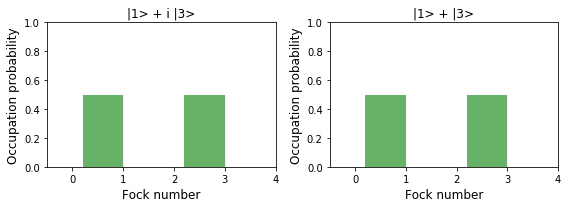

In [4]:
# the fock state probability distribution for our target state (fig 2d)
target1 = (fock(4,1) + 1j*fock(4,3)).unit()
target2 = (fock(4,1) + fock(4,3)).unit()

fig, axes = plt.subplots(1, 2, figsize=(8,3))
plot_fock_distribution(target, fig=fig, ax=axes[0], title="|1> + i |3>");
plot_fock_distribution(target2, fig=fig, ax=axes[1], title="|1> + |3>"); 
fig.tight_layout()
plt.show()

## Wigner Functions

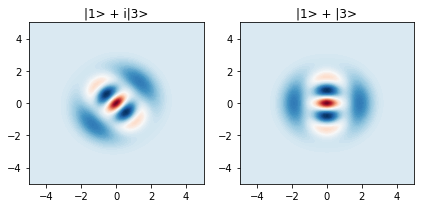

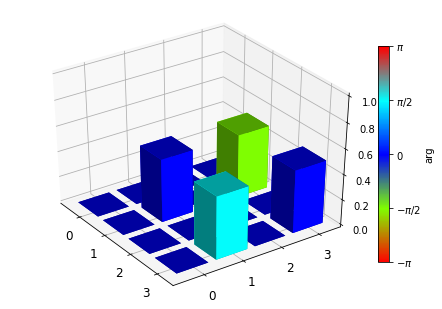

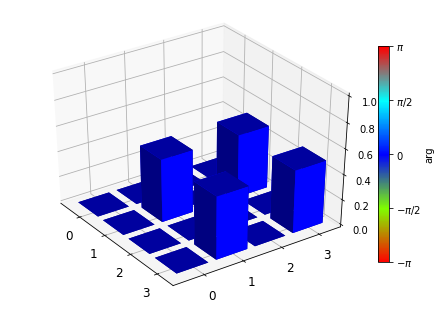

In [36]:
# now we're talking
xvec = np.linspace(-5,5,200)
W_target = wigner(target, xvec, xvec)
W_target2 = wigner(target2, xvec, xvec)
rho_target = ket2dm(target)
rho_target2 = ket2dm(target2)

# real deal plots
fig, axes = plt.subplots(1, 2, figsize=(6,3))
cont0 = axes[0].contourf(xvec, xvec, W_target, 100, cmap=cm.RdBu)
lbl0 = axes[0].set_title("|1> + i|3>")
cont1 = axes[1].contourf(xvec, xvec, W_target2, 100, cmap=cm.RdBu)
lbl1 = axes[1].set_title("|1> + |3>")
plt.tight_layout()
plt.show()

# density matrix histograms
matrix_histogram_complex(rho_target)
matrix_histogram_complex(rho_target2)
plt.show()

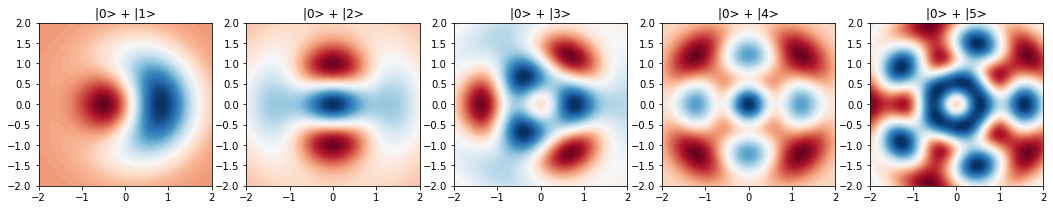

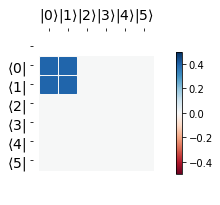

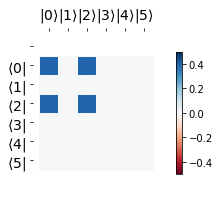

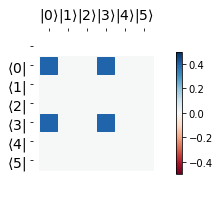

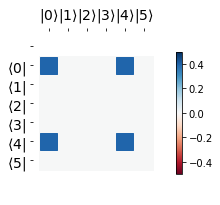

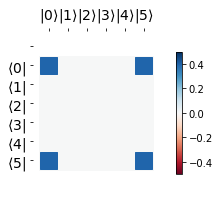

In [31]:
# figure 3 of Hofheinz et al
xvec = np.linspace(-2,2,200)
rho_fig3 = [] # density matrices
W_fig3 = [] # wigner functions
cont = [] # contours
for m in range(5):
    ket = (fock(6,0)+fock(6,m+1)).unit()
    rho_fig3.append(ket2dm(ket))
    W_fig3.append(wigner(ket, xvec, xvec))
    cont.append(0) # placeholder

fig, axes = plt.subplots(1, 5, figsize=(18,3))
for m in range(5):
    cont[m] = axes[m].contourf(xvec, xvec, W_fig3[m], 100, cmap=cm.RdBu)
    axes[m].set_title("|0> + |%d>" % (m+1))
plt.show()

# need density matrices
# fig2, axes2 = plt.subplots(1, 5, figsize=(18,3))
for m in range(5):
    fig, axes = plt.subplots(1,1, figsize=(3,3))
    hinton(rho_fig3[m], ax=axes)
plt.show()


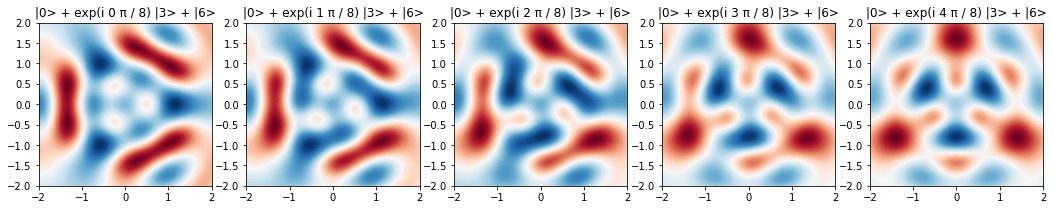

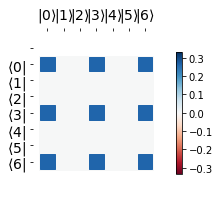

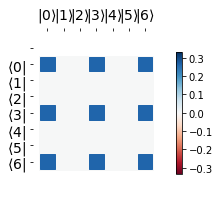

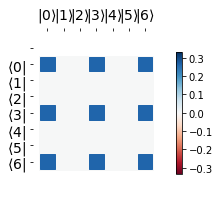

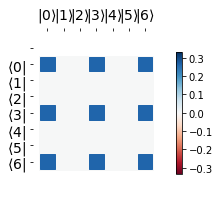

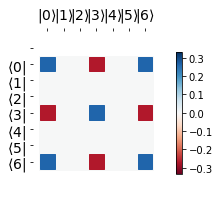

In [39]:
# figure 4 of Hofheinz et al
xvec = np.linspace(-2,2,200)
W_fig4 = [] # wigner functions
rho_fig4 = [] # density matrices

for k in range(5):
    ket = (fock(7, 0) + np.exp(1j * k * np.pi / 8) * fock(7, 3) + fock(7, 6)).unit()
    W_fig4.append(wigner(ket, xvec, xvec))
    rho_fig4.append(ket2dm(ket))

fig, axes = plt.subplots(1, 5, figsize=(18,3))
for m in range(5):
    cont[m] = axes[m].contourf(xvec, xvec, W_fig4[m], 100, cmap=cm.RdBu)
    axes[m].set_title("|0> + exp(i %d π / 8) |3> + |6>" % (m))
plt.show()

# BUGGY - doesn't show phase
for m in range(5):
    fig, axes = plt.subplots(1,1, figsize=(3,3))
    hinton(rho_fig4[m], ax=axes)
plt.show()